In [3]:
import numpy as np
import cmath
import math
from matplotlib.pyplot import *

In [4]:
#Message and interference are randomly generated Lorem Ipsum text, both of 300 characters

A = str(open("../message.txt","r").read())
interference = str(open("../noise.txt", "r").read())
#phi = alphabetical order of 1st letter of surname + 2x alphabetical order of 1st letter of surname
#phi = 5 + 2(19) = 43
phi = math.radians(43) #in radians

31.583333333333332%


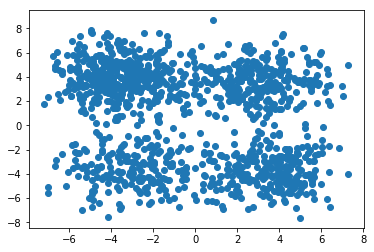

In [108]:
B = sourceEncoder(A) #each character in A is returned as an 8-bit utf-8 encoded binary

T = digitalModulator(B, phi) #returns the stream of symbols, 4 symbols per character: ie 1200 symbols
#ignoring the carrier, T is the transmitted signal
#T_ = channel(T)
#T_ = channel(T, SNRin = 30)
#T_ = channel(T, SNRin = 15)
#T_ = channel(T, SNRin = 1)

#jamming channel:
SNRj = 10 #SNRj is how much more powerful the jamming signal is than the desired signal
encodedInterference = sourceEncoder(interference)
modulatedIntereference = digitalModulator(encodedInterference) #at this point assuming that the jamming signal has no phase difference to a 'standard' QPSK system with phi=pi/4 offset
jam = (modulatedIntereference, SNRj)
T_ = channel(T, SNRin = 1, jammer = jam)



#t_real = [i.real for i in T_]
#t_imag = [i.imag for i in T_]
#fig,ax = subplots()
#ax.scatter(t_real, t_imag)


B_ = digitalDemodulator(T_)

try:
    A_ = sourceDecoder(B_)
except:
    print("Decoding error, bit error caused an invalid UTF-8 byte code")
error = errorPercent(B_, A)
print(str(error) + "%")


In [55]:
def errorPercent(Rx, Tx):
    Tx = sourceEncoder(Tx)
    Tx_join = ""
    Rx_join = ""
    for r in Rx:
        Rx_join += r
    for t in Tx:
        Tx_join += t
    error = 0
    for r, t in list(zip(Rx_join, Tx_join)):
        if r != t:
            error += 1
    return 100 * error/len(Tx_join) 

In [6]:
def sourceDecoder(B_):
    byte_list = []
    A_ = ""
    B_copy = B_.copy()
    while len(B_copy) > 0:
        #print(len(B_))
        symbol = B_copy[0] + B_copy[1] + B_copy[2] + B_copy[3]
        del B_copy[0:4]
        byte_list.append(symbol)
        
    for byte in byte_list:
        temp = int(byte, 2).to_bytes(1, byteorder = "big")
        A_ += temp.decode()
    return A_
    

In [7]:
def digitalDemodulator(T_):
    B_ = []
    for i in T_:
        distances = pointDistance(i)
        B_.append(min(distances, key = distances.get))
    return B_
        
def pointDistance(point):
    symbols = {"00":cmath.rect(math.sqrt(2), phi), 
            "01":cmath.rect(math.sqrt(2), phi + cmath.pi/2),
            "11":cmath.rect(math.sqrt(2), phi + cmath.pi),
            "10":cmath.rect(math.sqrt(2), phi + (3*cmath.pi)/2)
            }
    symbols["00"] = abs(point - symbols["00"])
    symbols["01"] = abs(point - symbols["01"])
    symbols["11"] = abs(point - symbols["11"])
    symbols["10"] = abs(point - symbols["10"])
    return symbols

In [33]:
def channel(T, k = 1, SNRin = None, jammer = None):
    #SNRin should be given in dB
    #k is the signal attenuation of the channel
    #jammer is a tuple with the jamming message and the power of the jammer
        #jammer[0] is the jamming message, jammer[1] is the relative power of the jamming signal in dBs compared to the message signal
    T = [k*t for t in T]
    
    Ps = signalPower(T)
    
    if SNRin != None: 
        SNRlin = 10**(SNRin/10)
        Pn = Ps/SNRlin
        T = addAWGN(T, Pn)
    
    if jammer != None:
        SNRj_lin = 10**(jammer[1]/10)
        Pj = Ps * SNRj_lin
        interference = formInterference(jammer[0], Pj)
        T = addInterference(T, interference)
    return T

def addInterference(T, interference):
    jammedT = []
    for t, i in list(zip(T, interference)):
        jammedT.append(t + i)
    return jammedT
    
def formInterference(interference, Pj):
    initialPower = signalPower(interference)
    scale = Pj/initialPower
    return [i*math.sqrt(scale) for i in interference]

def addAWGN(T, Pn):
    n_r = []
    n_i = []
    for i in T:
        n_r.append(np.random.normal(scale = math.sqrt(Pn)))
        n_i.append(np.random.normal(scale = math.sqrt(Pn)))
    return [T[i] + complex(n_r[i], n_i[i]) for i in range(len(T))]

def signalPower(T):
    summation = 0
    for i in T:
        summation += (abs(i))**2
    return summation/len(T)

In [9]:
def digitalModulator(B, phi = cmath.pi/4):
    T = []
    symbols = {"00":cmath.rect(math.sqrt(2), phi), 
               "01":cmath.rect(math.sqrt(2), phi + cmath.pi/2),
               "11":cmath.rect(math.sqrt(2), phi + cmath.pi),
               "10":cmath.rect(math.sqrt(2), phi + (3*cmath.pi)/2)
               }
    for i in B:
        T.append(symbols[i[0:2]])
        T.append(symbols[i[2:4]])
        T.append(symbols[i[4:6]])
        T.append(symbols[i[6:8]])
    return(T)
            

In [10]:
def sourceEncoder(m):
    #Creates a list of 8 digit binary characters for the message, returns as a string
    binary = list(map(bin,bytearray(m,'UTF-8')))
    binary = [str(b[2:]) for b in binary]
    for b in range(len(binary)):
        while len(binary[b]) < 8:
            binary[b] = "0" + binary[b]
    return(binary)